# MNIST Handwritten Digit Recognition
This notebook demonstrates how to train a Convolutional Neural Network (CNN) to recognize handwritten digits from the MNIST dataset using PyTorch.


## Imports and Setup


In [25]:
#!pip install torch
#!pip install torchvision
#!pip install matplotlib
#!pip install datasets

In [26]:
import torch
import torch.nn as nn
from torchvision import transforms
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

## Dataset - `MNISTDataset`

The `MNISTDataset` class is a custom PyTorch Dataset that handles loading and transforming the MNIST images. It takes raw image data from Huggingface datasets and applies specified transformations (e.g., converting to tensor, normalization).


In [27]:
class MNISTDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample["image"]
        label = sample["label"]

        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __repr__(self):
        return f"MNISTDataset(data={len(self.data)})"


### Data Loader

Here, we load the MNIST dataset using the `datasets` library, define transformations for the images, and create `DataLoader` objects for efficient batching training and evaluation.


In [32]:
# Load MNIST dataset
dataset = load_dataset("mnist")
train_data = dataset["train"]
test_data = dataset["test"]

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create custom datasets
train_dataset = MNISTDataset(train_data, transform)
test_dataset = MNISTDataset(test_data, transform)

# Create DataLoaders
batch_size = 100
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=0
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

print(train_dataset)
print(test_dataset)

MNISTDataset(data=60000)
MNISTDataset(data=10000)


### Sample Images
Before starting the training we visualize the data for some sample images.

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # Get a random image from the training dataset
    idx = random.randint(0, len(train_data) - 1)
    image = train_data[idx]["image"]
    label = train_data[idx]["label"]
    
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()


## Model - `MNISTModel`

The `MNISTModel` is a Convolutional Neural Network (CNN) designed for classifying MNIST digits. It consists of multiple convolutional layers followed by fully connected layers.


In [ ]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(512, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))           # 1 x 26 x 26 x 4
        x = self.conv2(x)                       # 4 x 24 x 24 x 8
        x = torch.max_pool2d(x, kernel_size=2)  # 4 x 12 x 12 x 8
        x = torch.relu(self.conv3(x))           # 8 x 10 x 10 x 16
        x = torch.relu(self.conv4(x))           # 16 x 8 x 8 x 32
        x = torch.max_pool2d(x, kernel_size=2)  # 16 x 4 x 4 x 32
        x = x.view(-1, 512)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Model Parameters
This function counts and prints the total number of trainable parameters in the model, along with a breakdown per layer.


In [ ]:
def count_parameters(model):
    total_params = 0
    print("\nModel Parameter Breakdown:")
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        print(f"Layer: {name:<20} | Parameters: {param}")
    print(f"\nTotal Trainable Parameters: {total_params}")
    return total_params


### Test Accuracy
This function evaluates the model's accuracy on the provided test dataset.


In [36]:
def evaluate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


## Training

The `train` function orchestrates the entire training process, including model instantiation, optimizer setup, and the iterative training loop. It also periodically evaluates the model's accuracy on the test set.


In [ ]:
def train():
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create model
    model = MNISTModel().to(device)
    count_parameters(model)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Define number of epochs
    num_epochs = 5

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {int(i/100 if i > 0 else 0)}, Records {i*len(images)}, Loss: {loss.item()}")
                
                # Visualize some images and their predictions during training
                fig = plt.figure(figsize=(8, 4))
                for j in range(min(4, images.shape[0])):
                    plt.subplot(1, 4, j + 1)
                    plt.imshow(images[j].squeeze().cpu().numpy(), cmap='gray')
                    predicted_label = torch.argmax(outputs[j]).item()
                    true_label = labels[j].item()
                    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
        accuracy = evaluate_accuracy(model, test_loader, device) # Pass device to evaluate_accuracy
        print(f"Accuracy on test data: {accuracy:.2f}%")
        break;

Using device: cpu

Model Parameter Breakdown:
Layer: conv1.weight         | Parameters: 36
Layer: conv1.bias           | Parameters: 4
Layer: conv2.weight         | Parameters: 288
Layer: conv2.bias           | Parameters: 8
Layer: conv3.weight         | Parameters: 1152
Layer: conv3.bias           | Parameters: 16
Layer: conv4.weight         | Parameters: 4608
Layer: conv4.bias           | Parameters: 32
Layer: fc1.weight           | Parameters: 10240
Layer: fc1.bias             | Parameters: 20
Layer: fc2.weight           | Parameters: 200
Layer: fc2.bias             | Parameters: 10

Total Trainable Parameters: 16614
Epoch 1, Batch 0, Records 0, Loss: 2.3127801418304443
Model is in True mode


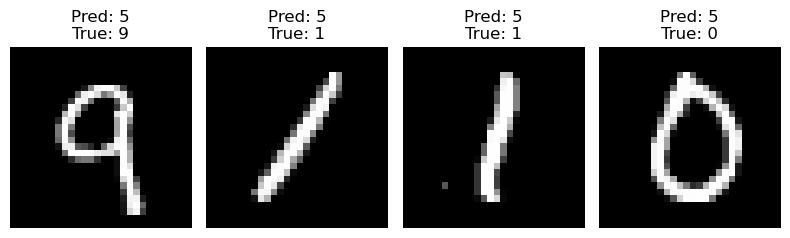

Epoch 1, Batch 1, Records 10000, Loss: 0.48833271861076355
Model is in True mode


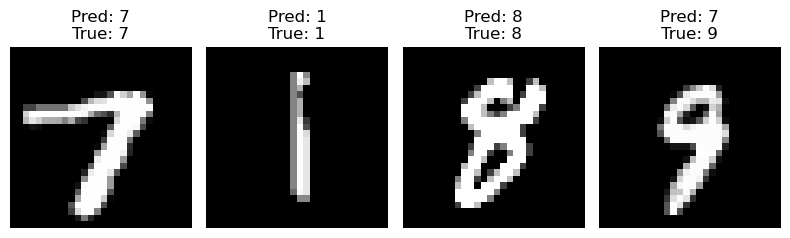

Epoch 1, Batch 2, Records 20000, Loss: 0.21967126429080963
Model is in True mode


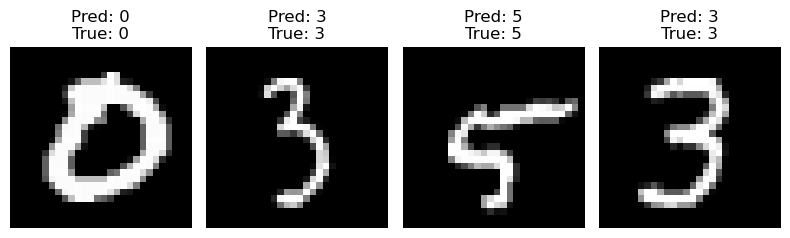

Epoch 1, Batch 3, Records 30000, Loss: 0.16183872520923615
Model is in True mode


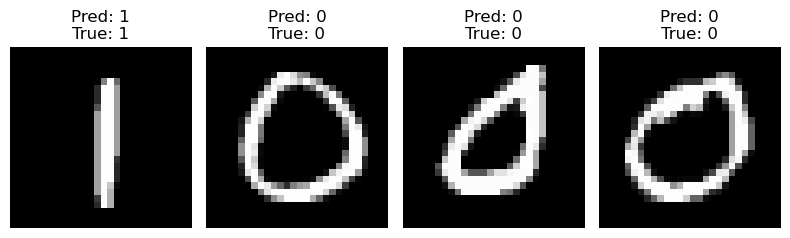

Epoch 1, Batch 4, Records 40000, Loss: 0.1598765105009079
Model is in True mode


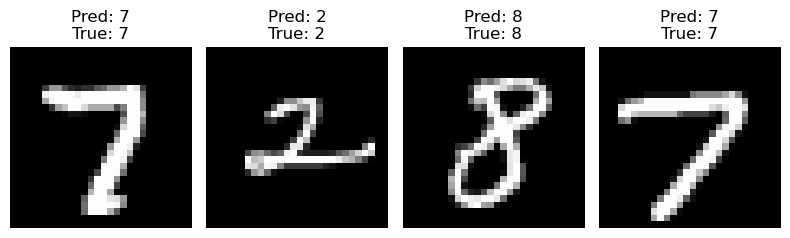

Epoch 1, Batch 5, Records 50000, Loss: 0.12166000157594681
Model is in True mode


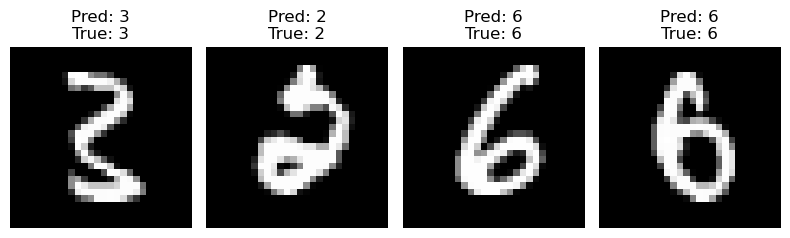

Accuracy on test data: 97.18%


In [44]:
if __name__ == "__main__":
    train()

## Visualize Transformations

This section will demonstrate how a sample image is transformed as it passes through the convolutional and max-pooling layers of the `MNISTModel`.


Using device for visualization: mps
Visualizing transformations for an image with true label: 2


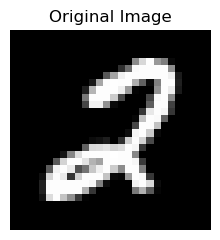

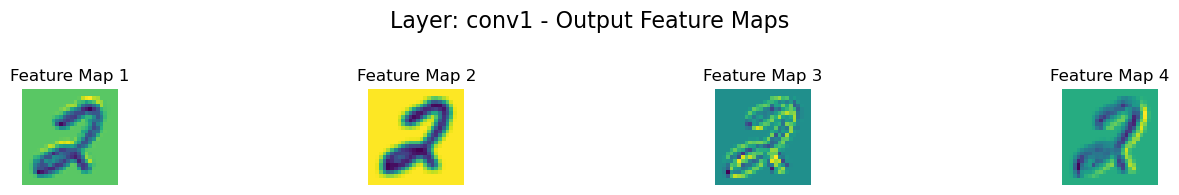

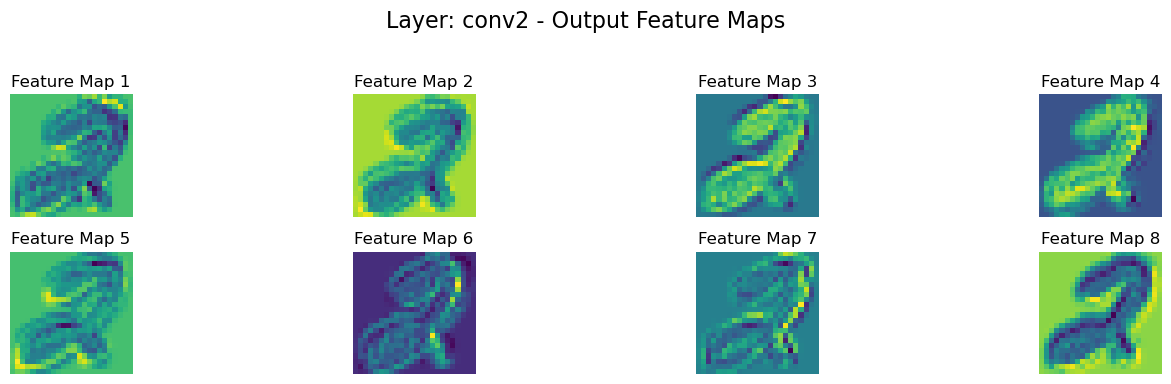

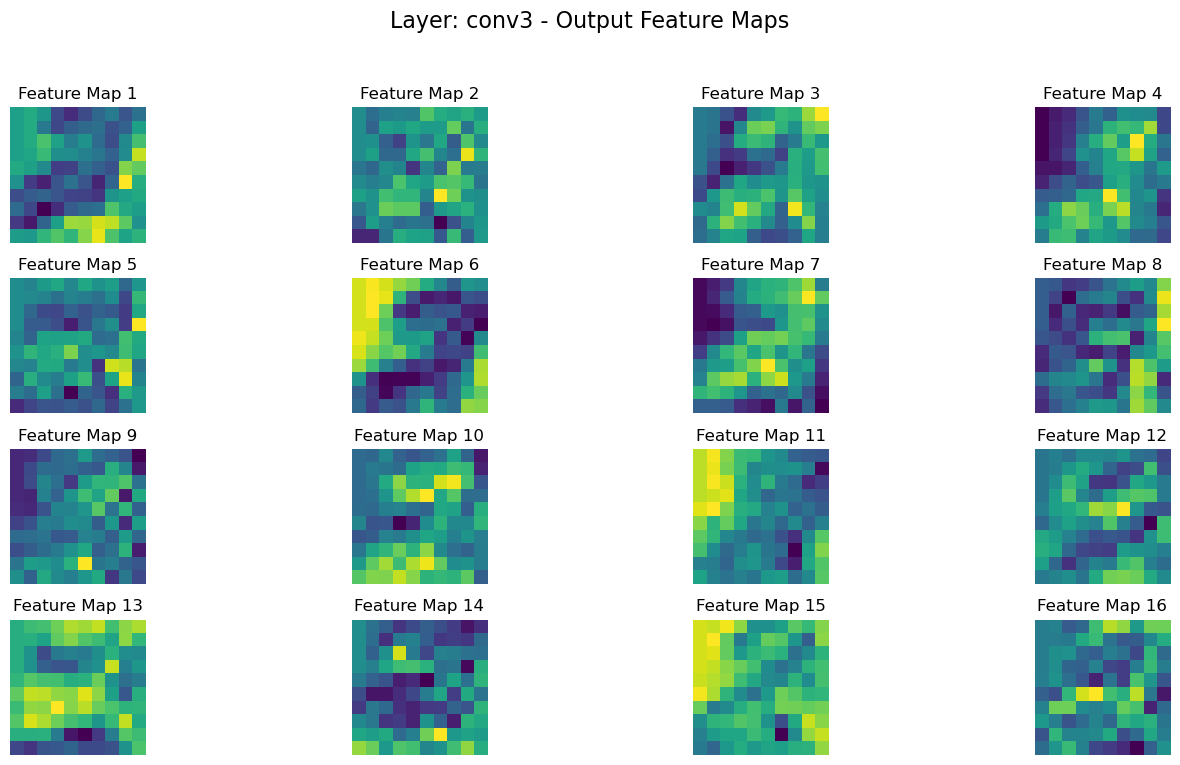

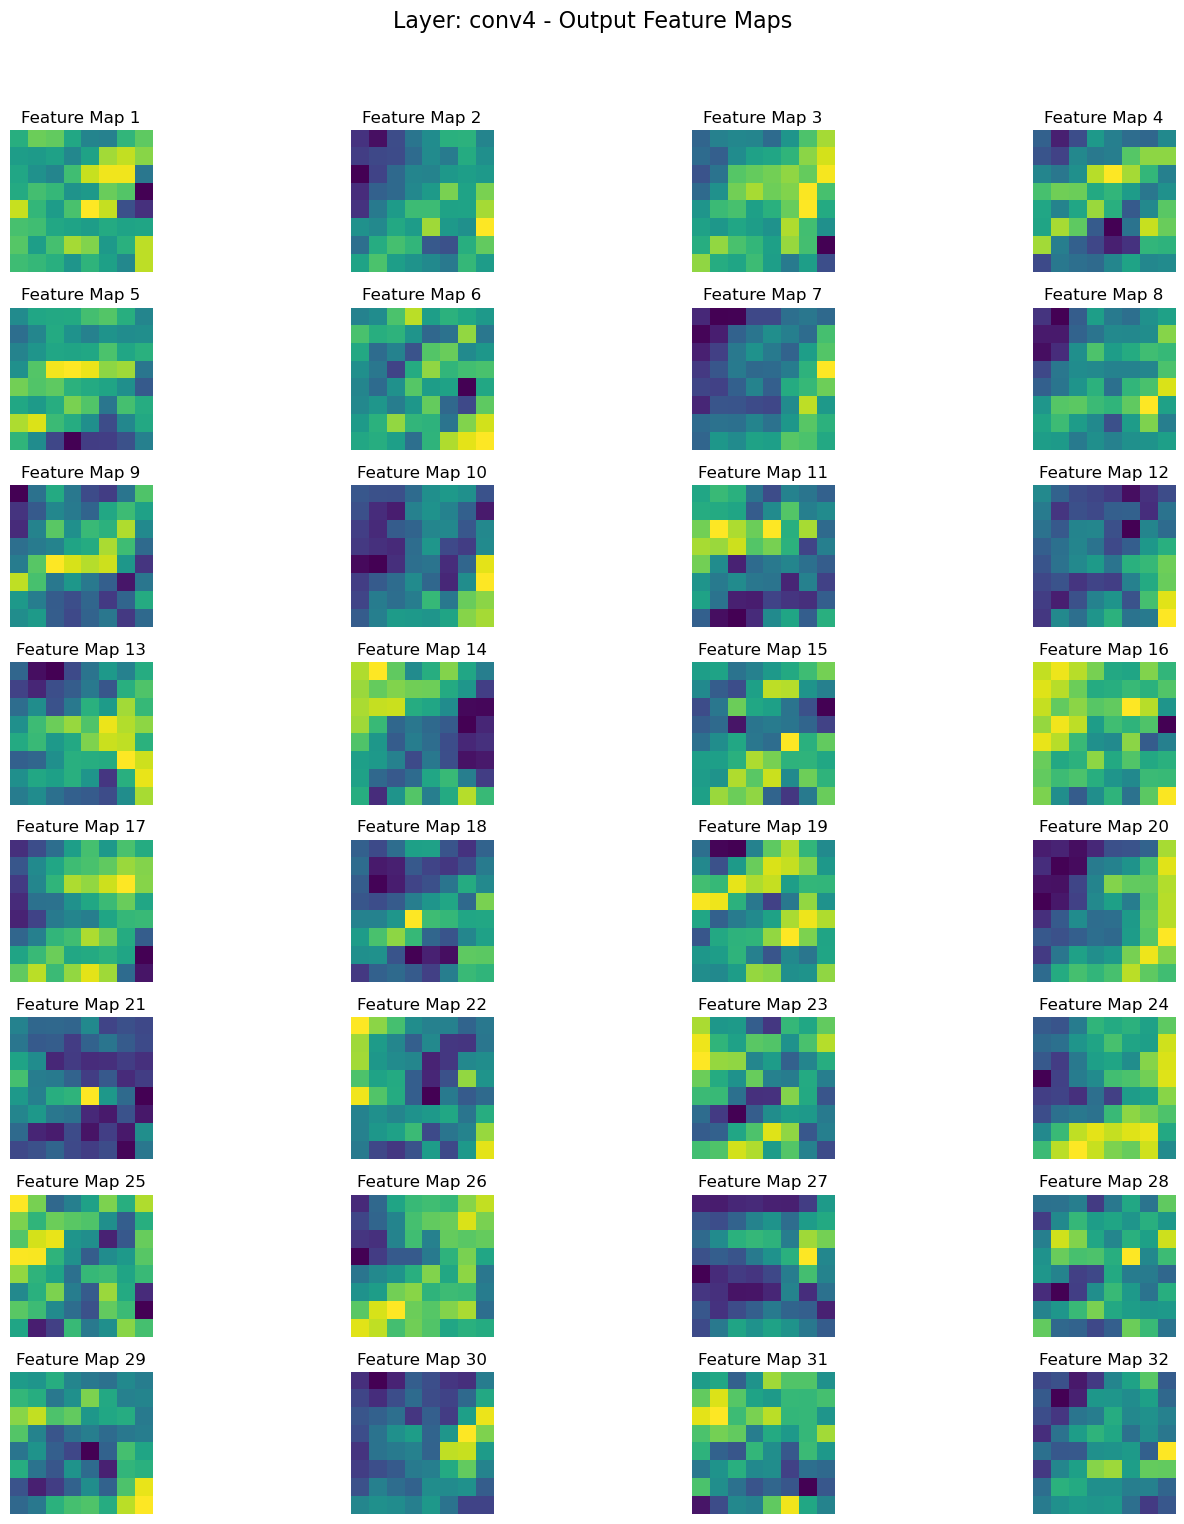

In [ ]:
import numpy as np

def visualize_layer_output(model, image, layer_names, device):
    # Model is in evaluation mode
    model.eval()
    
    # Store outputs of intermediate layers
    outputs = {}
    
    def get_activation(name):
        def hook(model, input, output):
            outputs[name] = output.detach()
        return hook

    # Register hooks for the layers we want to visualize
    hooks = []
    for name, layer in model.named_children():
        if name in layer_names:
            hooks.append(layer.register_forward_hook(get_activation(name)))
    
    # Pass the image through the model
    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device)) # Add batch dimension and move to device
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
        
    # Plot the original image
    plt.figure(figsize=(15, 8))
    plt.subplot(1, len(layer_names) + 1, 1)
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot feature maps for each selected layer
    for i, name in enumerate(layer_names):
        feature_maps = outputs[name].squeeze().cpu().numpy()
        
        num_feature_maps = feature_maps.shape[0] if feature_maps.ndim == 3 else 1
        cols = 4 # Number of columns for displaying feature maps
        rows = (num_feature_maps + cols - 1) // cols
        
        fig2 = plt.figure(figsize=(15, rows * 2))
        for j in range(num_feature_maps):
            plt.subplot(rows, cols, j + 1)
            plt.imshow(feature_maps[j], cmap='viridis')
            plt.title(f'Feature Map {j+1}')
            plt.axis('off')
        fig2.suptitle(f'Layer: {name} - Output Feature Maps', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Instantiate the model (we might need to load trained weights for meaningful visualization)
# Device configuration
device_viz = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device for visualization: {device_viz}")
model_viz = MNISTModel().to(device_viz)

# For demonstration, let's take a random image from the test set
random_idx = random.randint(0, len(test_data) - 1)
sample_image, sample_label = test_dataset[random_idx]

print(f"Visualizing transformations for an image with true label: {sample_label}")

# Define the layers to visualize (names as defined in MNISTModel)
layers_to_visualize = ['conv1', 'conv2', 'conv3', 'conv4']

visualize_layer_output(model_viz, sample_image, layers_to_visualize, device_viz)
